# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [2]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [3]:
britney_df = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [4]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1193, 21)

In [5]:
britney_df = britney_df.dropna()
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1189,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1190,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1191,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [6]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [7]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [8]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [9]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [10]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

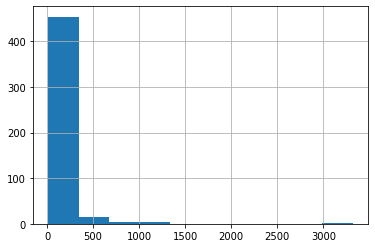

In [11]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

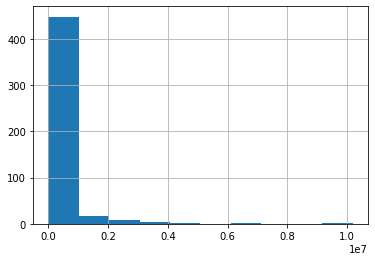

In [12]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [13]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [14]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [15]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [16]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [17]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [18]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [19]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [20]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [21]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [22]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [23]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


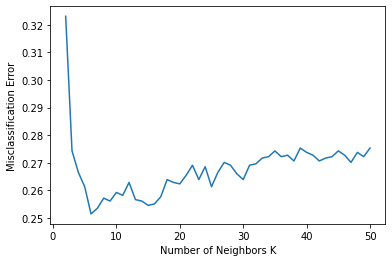

The optimal number of neighbors is 6 with score 74%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


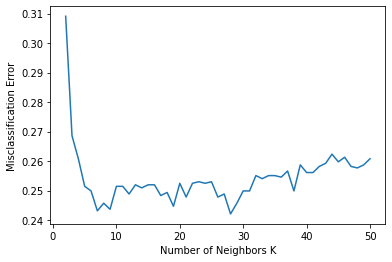

The optimal number of neighbors is 28 with score 75%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


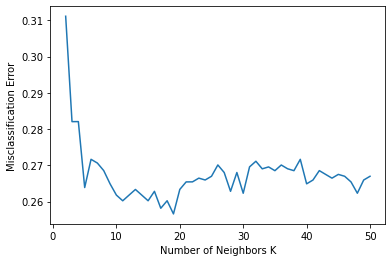

The optimal number of neighbors is 19 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


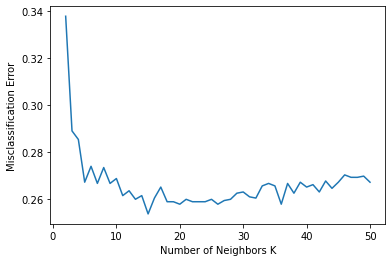

The optimal number of neighbors is 15 with score 74%


In [24]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X_train, Y_train)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [25]:
results_optimal_k

[6, 28, 19, 15]

### 5. Model Prediction

In [26]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [27]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [28]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 15


In [29]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
474,1N90cV79gbBgO0bOs74Y0t,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,56mWuvukxl5ylhGoa0OBzw,229640,2017-03-31,52,0.786,0.735,...,0.747,0.354127,4,reggae,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
1266,5B03nSG8pLE48jh7kmasuL,Levels - Radio Edit,1vCWHaC5f2uS3yhpwWbIA6,Avicii,16WbLPydnmtI3gQJ4MHZ9J,201920,2013-01-01,42,0.579,0.887,...,0.472,0.452067,2,jazz,1.0,0.000000,0.400000,0.066667,0.400000,0.133333
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.000000,0.266667,0.000000,0.600000,0.133333
1249,5JdgWizARB8aeeQwbT38wt,Cebuana,0touaoSr4QOLYxBJ9lmGgK,Karencitta,0A3uGl1bn150flpBl625ig,210873,2018-04-13,31,0.832,0.791,...,0.507,0.279852,4,reggae,1.0,0.000000,0.400000,0.000000,0.333333,0.266667
2899,1DnpjwTbSwV2V6O4PABMjW,my tears ricochet,06HL4z0CvFAxyc27GXpf02,Taylor Swift,0xS0iOtxQRoJvfcFcJA5Gv,255893,2020-07-24,41,0.456,0.263,...,0.111,0.475566,2,jazz,1.0,0.133333,0.066667,0.400000,0.400000,0.000000


Check out tracks with highest assigned probability

In [30]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
474,Calvin Harris,"Heatstroke (feat. Young Thug, Pharrell William...",reggae,1.000000
1266,Avicii,Levels - Radio Edit,jazz,1.000000
3335,ROSÉ,On The Ground,pop,1.000000
1249,Karencitta,Cebuana,reggae,1.000000
2899,Taylor Swift,my tears ricochet,jazz,1.000000
1067,Camila Cabello,Inside Out,reggae,1.000000
1999,Rex Orange County,Happiness,jazz,1.000000
3185,ENHYPEN,Outro : Cross the Line,jazz,1.000000
2019,Marion Aunor,Akala,jazz,1.000000
2834,HONNE,dear P,classical,1.000000


View histogram of predicted genre probabilities

<AxesSubplot:>

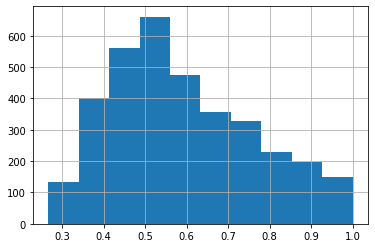

In [31]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [32]:
chart_tracks_df['predicted_genre'].value_counts()

pop          1367
reggae        984
country       621
jazz          501
classical      16
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [33]:
this_song = 'Lay Me Down'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('Lay Me Down')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
762,64GRDrL1efgXclrhVCeuA0,Lay Me Down,2wY79sveU1sp5g7SokKOiI,Sam Smith,0vrWqbRQEMKqhTGcDLQK7x,219535,2015-11-06,75,0.468,0.19,...,0.326,0.447624,2,jazz,0.866667,0.0,0.066667,0.0,0.466667,0.466667


In [34]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [35]:
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
474,1N90cV79gbBgO0bOs74Y0t,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,56mWuvukxl5ylhGoa0OBzw,229640,2017-03-31,52,0.786,0.735,...,0.747,0.354127,4,reggae,1.0,0.000000,0.000000,0.000000,0.000000,1.000000
1266,5B03nSG8pLE48jh7kmasuL,Levels - Radio Edit,1vCWHaC5f2uS3yhpwWbIA6,Avicii,16WbLPydnmtI3gQJ4MHZ9J,201920,2013-01-01,42,0.579,0.887,...,0.472,0.452067,2,jazz,1.0,0.000000,0.400000,0.066667,0.400000,0.133333
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.000000,0.266667,0.000000,0.600000,0.133333
1249,5JdgWizARB8aeeQwbT38wt,Cebuana,0touaoSr4QOLYxBJ9lmGgK,Karencitta,0A3uGl1bn150flpBl625ig,210873,2018-04-13,31,0.832,0.791,...,0.507,0.279852,4,reggae,1.0,0.000000,0.400000,0.000000,0.333333,0.266667
2899,1DnpjwTbSwV2V6O4PABMjW,my tears ricochet,06HL4z0CvFAxyc27GXpf02,Taylor Swift,0xS0iOtxQRoJvfcFcJA5Gv,255893,2020-07-24,41,0.456,0.263,...,0.111,0.475566,2,jazz,1.0,0.133333,0.066667,0.400000,0.400000,0.000000


In [36]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob'],
      dtype='object')

In [37]:
#read data
britney_df=pd.read_csv("data/Britney_Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.713767,0,0.0307,0.2020,0.000131,0.4430,0.907,0.218504,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.807438,0,0.1140,0.0249,0.025000,0.2420,0.924,0.550393,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.729166,0,0.0437,0.3000,0.000018,0.3550,0.894,0.232375,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,0.740318,1,0.0622,0.0730,0.000000,0.0889,0.235,0.523619,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,0.847496,1,0.0334,0.2500,0.000678,0.0723,0.382,0.353460,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [38]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [39]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [40]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [41]:
seed_track_data = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
scaler = MinMaxScaler()
seed_track_data['loudness'] = scaler.fit_transform(seed_track_data[['loudness']])
seed_track_data['tempo'] =  scaler.fit_transform(seed_track_data[['tempo']])
#seed_track_data = seed_track_data[feature_cols].iloc[1]
seed_track_data = seed_track_data[feature_cols].mean()
seed_track_data

danceability        0.666693
energy              0.728810
loudness            0.725647
speechiness         0.080287
acousticness        0.136064
instrumentalness    0.011355
liveness            0.182987
valence             0.600610
tempo               0.392383
dtype: float64

In [42]:
#seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
#seed_track_data

In [43]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [44]:
chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2301,Graveyard,Halsey,0.000307,pop,0.667,0.583,0.782927,0.0747,0.23100,0.000045,0.1810,0.1870,0.242872
2825,Maria,Hwa Sa,0.000307,reggae,0.667,0.745,0.871648,0.0621,0.23800,0.000002,0.2550,0.4820,0.470102
2958,you broke me first,Tate McRae,0.000307,jazz,0.667,0.373,0.608434,0.0500,0.78500,0.000000,0.0906,0.0823,0.440419
2613,In Your Eyes,The Weeknd,0.000307,country,0.667,0.719,0.772938,0.0346,0.00285,0.000081,0.0736,0.7170,0.291962
398,TG4M,Zara Larsson,0.000307,country,0.667,0.648,0.730890,0.0626,0.02350,0.000015,0.0427,0.5890,0.261257
777,MIC Drop,BTS,0.000307,pop,0.667,0.889,0.794227,0.0918,0.00912,0.000000,0.0816,0.5410,0.722302
73,One Call Away,Charlie Puth,0.000307,country,0.667,0.613,0.773675,0.0344,0.40300,0.000000,0.1150,0.4700,0.236601
1188,Everyday,Logic,0.000307,pop,0.667,0.741,0.825015,0.0378,0.04250,0.000000,0.0761,0.4220,0.598924
31,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,0.000307,pop,0.667,0.830,0.758854,0.0749,0.01230,0.000000,0.1910,0.7010,0.372008
691,Hericane,LANY,0.000693,pop,0.666,0.435,0.659406,0.0319,0.41000,0.000295,0.1120,0.1480,0.512743


In [45]:
chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2301,Graveyard,Halsey,0.000307,pop,0.667,0.583,0.782927,0.0747,0.23100,0.000045,0.1810,0.1870,0.242872
2825,Maria,Hwa Sa,0.000307,reggae,0.667,0.745,0.871648,0.0621,0.23800,0.000002,0.2550,0.4820,0.470102
2958,you broke me first,Tate McRae,0.000307,jazz,0.667,0.373,0.608434,0.0500,0.78500,0.000000,0.0906,0.0823,0.440419
2613,In Your Eyes,The Weeknd,0.000307,country,0.667,0.719,0.772938,0.0346,0.00285,0.000081,0.0736,0.7170,0.291962
398,TG4M,Zara Larsson,0.000307,country,0.667,0.648,0.730890,0.0626,0.02350,0.000015,0.0427,0.5890,0.261257
777,MIC Drop,BTS,0.000307,pop,0.667,0.889,0.794227,0.0918,0.00912,0.000000,0.0816,0.5410,0.722302
73,One Call Away,Charlie Puth,0.000307,country,0.667,0.613,0.773675,0.0344,0.40300,0.000000,0.1150,0.4700,0.236601
1188,Everyday,Logic,0.000307,pop,0.667,0.741,0.825015,0.0378,0.04250,0.000000,0.0761,0.4220,0.598924
31,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,0.000307,pop,0.667,0.830,0.758854,0.0749,0.01230,0.000000,0.1910,0.7010,0.372008
691,Hericane,LANY,0.000693,pop,0.666,0.435,0.659406,0.0319,0.41000,0.000295,0.1120,0.1480,0.512743


In [46]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
674,Sharp Edges,Linkin Park,0.001085,country,0.652,0.714,0.760368,0.0562,0.1450,0.000000,0.154,0.624,0.365849
1331,134340,BTS,0.002216,country,0.664,0.688,0.728106,0.0543,0.1530,0.000091,0.173,0.650,0.328887
2324,Cry for Me,Camila Cabello,0.002802,reggae,0.721,0.805,0.823582,0.0927,0.0500,0.000000,0.153,0.653,0.402946
3017,Diamonds,Sam Smith,0.002998,country,0.653,0.667,0.715906,0.0423,0.1540,0.000000,0.107,0.556,0.317559
3134,Diamonds,Sam Smith,0.003096,country,0.637,0.666,0.715537,0.0494,0.1610,0.000000,0.108,0.529,0.316568
3361,LILAC,IU,0.003225,reggae,0.738,0.890,0.899693,0.0748,0.0895,0.000002,0.213,0.750,0.383773
2099,Do You Mean (feat. Ty Dolla $ign & bülow),The Chainsmokers,0.003297,country,0.600,0.666,0.590502,0.0394,0.1020,0.000000,0.118,0.566,0.291765
3122,motive (with Doja Cat),Ariana Grande,0.003310,reggae,0.789,0.742,0.760942,0.0652,0.0681,0.000000,0.166,0.661,0.396221
2312,TRICK IT,TWICE,0.003405,reggae,0.756,0.897,0.829150,0.0780,0.0895,0.000017,0.140,0.619,0.464355
279,Believer,Imagine Dragons,0.003413,reggae,0.779,0.787,0.816581,0.1080,0.0524,0.000000,0.140,0.708,0.445551


array([[<AxesSubplot:title={'center':'euclidean_dist'}>,
        <AxesSubplot:title={'center':'manhattan_dist'}>],
       [<AxesSubplot:title={'center':'cosine_dist'}>, <AxesSubplot:>]],
      dtype=object)

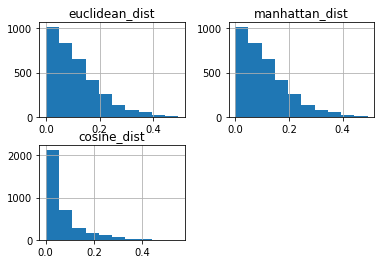

In [47]:
chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

In [52]:
#For filtering artists only
top_artists = pd.read_csv("data/spotify_daily_charts.csv")
top_artists['date'] = pd.to_datetime(top_artists['date'])
top_artists['year']= top_artists['date'].dt.year
yearly = top_artists[top_artists['position']<=50]

,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,predicted_genre_id,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob,euclidean_dist,manhattan_dist,cosine_dist
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,...,3489.000000,3489.000000,3484.000000,3484.000000,3484.000000,3484.000000,3484.000000,3489.000000,3489.000000,3489.000000
mean,215378.321869,48.257094,0.634342,0.603130,5.140155,0.716799,0.677271,0.082403,0.273121,0.009521,...,2.768702,0.595280,0.018408,0.213969,0.142977,0.365519,0.259127,0.112603,0.112603,0.069773
std,45662.339704,29.219434,0.140680,0.186345,3.597689,0.111542,0.467587,0.082375,0.272764,0.068324,...,1.060977,0.158956,0.066909,0.179510,0.234621,0.214984,0.286027,0.090304,0.090304,0.076720
min,37640.000000,0.000000,0.174000,0.025000,0.000000,0.000000,0.000000,0.023200,0.000002,0.000000,...,0.000000,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000307,0.000307,0.001085
25%,189286.000000,23.000000,0.545000,0.477000,2.000000,0.659980,0.000000,0.035800,0.047000,0.000000,...,2.000000,0.466667,0.000000,0.066667,0.000000,0.200000,0.000000,0.041693,0.041693,0.019932
50%,209800.000000,59.000000,0.650000,0.619000,5.000000,0.733920,1.000000,0.051500,0.171000,0.000000,...,3.000000,0.533333,0.000000,0.200000,0.000000,0.333333,0.133333,0.091693,0.091693,0.040915
75%,237520.000000,71.000000,0.735000,0.743000,8.000000,0.794596,1.000000,0.088800,0.449000,0.000018,...,4.000000,0.733333,0.000000,0.333333,0.200000,0.533333,0.466667,0.158307,0.158307,0.086261
max,536217.000000,100.000000,0.980000,0.978000,11.000000,1.000000,1.000000,0.884000,0.981000,0.908000,...,4.000000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000,0.492693,0.492693,0.548493


Modify similarity criteria

In [57]:
compet_cosine = chart_tracks_df.sort_values('cosine_dist', ascending=False).head(3)
compet_cosine.groupby(['track_name', 'artist_name'])[['cosine_dist']].max()

,,cosine_dist
track_name,artist_name,
Never Enough (Reprise),Loren Allred,0.503006
Pasko Na Sinta Ko,Gary Valenciano,0.520387
dear P,HONNE,0.548493


In [50]:
#collab_cosine = chart_tracks_df['cosine_dist'].mean().sort_values('cosine_dist', ascending=True).head(10)
compet_cosine = chart_tracks_df.groupby('artist_name')[['cosine_dist']].mean().sort_values('cosine_dist', ascending=True).reset_index().head(50)
high_cos = list(compet_cosine.artist_name.values)
#collab_cosine.groupby('artist_name').size().sort_values(ascending=False)

In [51]:
high_cos_artists = list(yearly[yearly.artist.isin(high_cos)]['artist'].unique())
compet_cosine[compet_cosine.artist_name.isin(high_cos_artists)][:3]

NameError: name 'yearly' is not defined

In [ ]:
#Filtering Artists
#ave streams = 107,264

#yearly[yearly['artist']=='Starley'] # --- FAILED = top on year 2017 only
#yearly[yearly['artist']=='AJR']['streams'].mean() # --- FAILED = 70136.72727272728 ave streams only

#yearly[yearly['artist']=='BTS'] # --- PASSED
#yearly[yearly['artist']=='BTS']['streams'].mean() # --- ave streams = 134090.87023593465

#yearly[yearly['artist']=='Camila Cabello'] # --- PASSED
#yearly[yearly['artist']=='Camila Cabello']['streams'].mean() # --- ave streams = 112520.33220910624

#yearly[yearly['artist']=='Sam Smith'] # --- PASSED
#yearly[yearly['artist']=='Sam Smith']['streams'].mean() # --- ave streams = 120574.13819095478

#FINAL 3 COLLABORATORS (ARTISTS WITH DIFFERENT GENRE --- LOWEST COSINE DISTANCE)
#1. BTS
#2. Camila Cabello
#3. Sam Smith

In [ ]:
compet_manhattan = chart_tracks_df.sort_values('manhattan_dist', ascending=True).head(10)
compet_manhattan.artist_name

#NOT RELIABLE --- BRITNEY SPEARS HERSELF IS AT THE BOTTOM 10

In [ ]:
compet_euclidean = chart_tracks_df.sort_values('euclidean_dist', ascending=True).head(10)
compet_euclidean.artist_name

#NOT RELIABLE --- BRITNEY SPEARS HERSELF IS AT THE BOTTOM 10

In [ ]:
#prediction = chart_tracks_df.sort_values('cosine_dist')
#prediction.groupby('predicted_genre')['popularity'].mean().sort_values(ascending=False)